# Component 1: Dataset Ingestion and Summary

This notebook:
- Loads all 11,743 MRI images
- Validates file integrity using SHA256 hashing
- Creates stratified train/val/test splits (70/15/15)
- Generates dataset manifest CSV
- Visualizes class distribution

In [1]:
import os
import hashlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

# Set random seed
SEED = 42
np.random.seed(SEED)

# Paths
DATA_DIR = '../data'
OUTPUT_DIR = '../outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"✓ Imports successful")
print(f"  Data directory: {DATA_DIR}")
print(f"  Output directory: {OUTPUT_DIR}")
print(f"  Random seed: {SEED}")

✓ Imports successful
  Data directory: ../data
  Output directory: ../outputs
  Random seed: 42


## 1.1 Load Images and Compute Metadata

In [2]:
def compute_sha256(filepath):
    """Compute SHA256 hash of file."""
    sha256_hash = hashlib.sha256()
    with open(filepath, 'rb') as f:
        for byte_block in iter(lambda: f.read(4096), b''):
            sha256_hash.update(byte_block)
    return sha256_hash.hexdigest()

def load_dataset_manifest(data_dir):
    """Load all images and create manifest."""
    
    # Get class directories
    class_dirs = sorted([d for d in os.listdir(data_dir) 
                        if os.path.isdir(os.path.join(data_dir, d)) and not d.startswith('.')])
    
    print(f"Found {len(class_dirs)} classes: {class_dirs}")
    
    # Map class names
    class_to_label = {name: idx for idx, name in enumerate(class_dirs)}
    
    data = []
    corrupted = []
    
    for class_name in class_dirs:
        class_dir = os.path.join(data_dir, class_name)
        image_files = [f for f in os.listdir(class_dir) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        print(f"\nProcessing {class_name}: {len(image_files)} images")
        
        for img_file in tqdm(image_files, desc=class_name):
            filepath = os.path.join(class_dir, img_file)
            
            try:
                # Try to open image
                img = Image.open(filepath)
                img.verify()  # Verify it's not corrupted
                img = Image.open(filepath)  # Reopen after verify
                
                # Get metadata
                width, height = img.size
                file_size = os.path.getsize(filepath)
                sha256 = compute_sha256(filepath)
                
                data.append({
                    'filepath': filepath,
                    'class_name': class_name,
                    'class_label': class_to_label[class_name],
                    'width': width,
                    'height': height,
                    'file_size_bytes': file_size,
                    'sha256_hash': sha256
                })
                
            except Exception as e:
                print(f"\n⚠️  Corrupted file: {filepath} - {e}")
                corrupted.append(filepath)
    
    df = pd.DataFrame(data)
    
    print(f"\n{'='*60}")
    print(f"Dataset Summary:")
    print(f"  Total images: {len(df)}")
    print(f"  Corrupted files: {len(corrupted)}")
    print(f"  Classes: {len(class_dirs)}")
    print(f"{'='*60}")
    
    return df, corrupted

# Load dataset
df, corrupted_files = load_dataset_manifest(DATA_DIR)
df.head()

Found 4 classes: ['1 Very Mild', '2 Mild', '3 Moderate', 'Normal']

Processing 1 Very Mild: 2240 images


1 Very Mild:   0%|          | 0/2240 [00:00<?, ?it/s]


Processing 2 Mild: 896 images


2 Mild:   0%|          | 0/896 [00:00<?, ?it/s]


Processing 3 Moderate: 503 images


3 Moderate:   0%|          | 0/503 [00:00<?, ?it/s]


Processing Normal: 8104 images


Normal:   0%|          | 0/8104 [00:00<?, ?it/s]


Dataset Summary:
  Total images: 11743
  Corrupted files: 0
  Classes: 4


,filepath,class_name,class_label,width,height,file_size_bytes,sha256_hash
0,../data/1 Very Mild/AD Very Mild 1303.jpg,1 Very Mild,0,256,256,20644,87b3d25bc70f98bd973e5823a89a5469155a849f9f3f64...
1,../data/1 Very Mild/AD Very Mild 924.jpg,1 Very Mild,0,256,256,20039,a0158c8f4baad4816d7f548d14e8a782dc7f6034ab27ef...
2,../data/1 Very Mild/AD Very Mild 1465.jpg,1 Very Mild,0,256,256,21475,2ba9861edfb9dffa5f345d4f80c28b6cf976655e4b06e0...
3,../data/1 Very Mild/AD Very Mild 1471.jpg,1 Very Mild,0,256,256,20982,105e6a59bb7bed47a37135e13b16ad867535ff13fddf93...
4,../data/1 Very Mild/AD Very Mild 2178.jpg,1 Very Mild,0,256,256,19611,1c91c2f7a857a8db343808e963c18c964fc2702569f4c9...


## 1.2 Save Dataset Manifest

In [3]:
# Save manifest
manifest_path = os.path.join(OUTPUT_DIR, 'dataset_manifest.csv')
df.to_csv(manifest_path, index=False)
print(f"✓ Dataset manifest saved to: {manifest_path}")

# Save corrupted files list if any
if corrupted_files:
    corrupted_path = os.path.join(OUTPUT_DIR, 'corrupted_files.txt')
    with open(corrupted_path, 'w') as f:
        f.write('\n'.join(corrupted_files))
    print(f"✓ Corrupted files list saved to: {corrupted_path}")

✓ Dataset manifest saved to: ../outputs/dataset_manifest.csv


## 1.3 Class Distribution Analysis


Class Distribution:
class_name
1 Very Mild    2240
2 Mild          896
3 Moderate      503
Normal         8104
Name: count, dtype: int64

Percentages:
class_name
1 Very Mild    19.08
2 Mild          7.63
3 Moderate      4.28
Normal         69.01
Name: count, dtype: float64

✓ Class distribution plot saved to: ../outputs/class_distribution.png


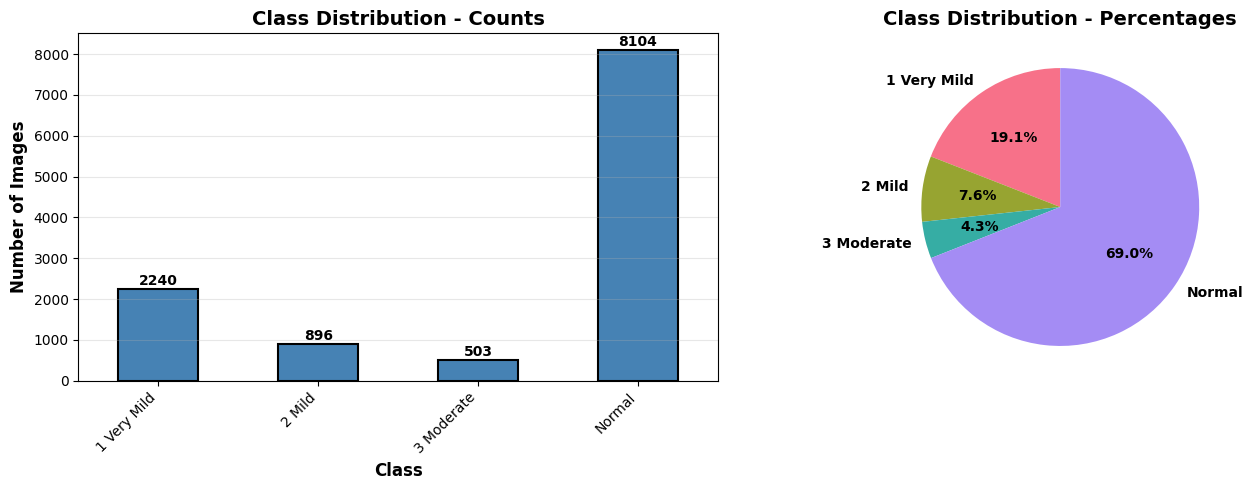

In [4]:
# Class counts
class_counts = df['class_name'].value_counts().sort_index()
print("\nClass Distribution:")
print(class_counts)
print(f"\nPercentages:")
print((class_counts / len(df) * 100).round(2))

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
class_counts.plot(kind='bar', ax=ax1, color='steelblue', edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Class', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Images', fontsize=12, fontweight='bold')
ax1.set_title('Class Distribution - Counts', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Add value labels
for i, v in enumerate(class_counts.values):
    ax1.text(i, v + 100, str(v), ha='center', fontweight='bold')

# Pie chart
colors = sns.color_palette('husl', len(class_counts))
ax2.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
       colors=colors, startangle=90, textprops={'fontsize': 10, 'fontweight': 'bold'})
ax2.set_title('Class Distribution - Percentages', fontsize=14, fontweight='bold')

plt.tight_layout()
plot_path = os.path.join(OUTPUT_DIR, 'class_distribution.png')
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Class distribution plot saved to: {plot_path}")
plt.show()

## 1.4 Create Stratified Splits (70/15/15)

In [5]:
# First split: 70% train, 30% temp
train_df, temp_df = train_test_split(
    df, test_size=0.30, stratify=df['class_label'], random_state=SEED
)

# Second split: 50% of temp for val, 50% for test (15% each of total)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, stratify=temp_df['class_label'], random_state=SEED
)

print(f"\nDataset Splits:")
print(f"  Train: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"  Val:   {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"  Test:  {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

# Verify stratification
print(f"\nClass distribution in splits:")
split_dist = pd.DataFrame({
    'Train': train_df['class_name'].value_counts().sort_index(),
    'Val': val_df['class_name'].value_counts().sort_index(),
    'Test': test_df['class_name'].value_counts().sort_index()
})
print(split_dist)


Dataset Splits:
  Train: 8220 (70.0%)
  Val:   1761 (15.0%)
  Test:  1762 (15.0%)

Class distribution in splits:
             Train   Val  Test
class_name                    
1 Very Mild   1568   336   336
2 Mild         627   134   135
3 Moderate     352    76    75
Normal        5673  1215  1216


## 1.5 Save Split Manifests

In [6]:
# Save split manifests
train_path = os.path.join(OUTPUT_DIR, 'train_manifest.csv')
val_path = os.path.join(OUTPUT_DIR, 'val_manifest.csv')
test_path = os.path.join(OUTPUT_DIR, 'test_manifest.csv')

train_df.to_csv(train_path, index=False)
val_df.to_csv(val_path, index=False)
test_df.to_csv(test_path, index=False)

print(f"✓ Train manifest saved to: {train_path}")
print(f"✓ Val manifest saved to: {val_path}")
print(f"✓ Test manifest saved to: {test_path}")

print(f"\n{'='*60}")
print("✅ COMPONENT 1 COMPLETE")
print(f"{'='*60}")
print(f"\nArtifacts created:")
print(f"  - {manifest_path}")
print(f"  - {train_path}")
print(f"  - {val_path}")
print(f"  - {test_path}")
print(f"  - {plot_path}")

✓ Train manifest saved to: ../outputs/train_manifest.csv
✓ Val manifest saved to: ../outputs/val_manifest.csv
✓ Test manifest saved to: ../outputs/test_manifest.csv

✅ COMPONENT 1 COMPLETE

Artifacts created:
  - ../outputs/dataset_manifest.csv
  - ../outputs/train_manifest.csv
  - ../outputs/val_manifest.csv
  - ../outputs/test_manifest.csv
  - ../outputs/class_distribution.png
